In [1]:
import os

# install relevant packages
INSTALL_PACKAGES = False

if INSTALL_PACKAGES:
    !pip install -q traci
    print("installed traci")
    !add-apt-repository ppa:sumo/stable -y > /dev/null
    print("add apt")
    !apt-get update -y > /dev/null
    print("apt update")
    !apt-get install -y sumo sumo-tools sumo-doc > /dev/null
    print("installed sumo")

    !pip install ipywidgets
    print("installed ipywidgets")
    
    os.environ['SUMO_HOME'] = "/usr/share/sumo/"

print("finished installing packages")

finished installing packages


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import traci
import random
import time
from collections import deque
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from traffic_generator import TrafficGenerator
from episodes_data import EpisodesData
from torch.nn.utils import clip_grad_norm_
import threading
import ipywidgets as widgets
from IPython.display import display
import csv

# set the precision for numpy output
np.set_printoptions(precision=4)

# set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

print("finished importing packages")

finished importing packages


In [3]:
# simulation configuration

# files
CONFIG_FILE = "./sumo_files/s2.sumocfg"
GUI_SETTINGS_FILE = "./sumo_files/viewsettings.xml"
ROU_FILE = "./sumo_files/s2.rou.xml"

# simulation command
SUMO_HEADLESS = "sumo"
SUMO_GUI = "sumo-gui"
SUMO_APP = SUMO_HEADLESS
STEP_LENGTH = "1"   # Simulation step length in seconds
TRAIN_MODEL_TIME_STEP = 4 # train the model every x seconds
TRAIN_MODEL_STEPS_SIZE = int(TRAIN_MODEL_TIME_STEP / float(STEP_LENGTH))
DELAY = "0"       # Simulation delay in seconds
DEBUG = False
EPISODES_GUI = 200

# simulation parameters
STATE_SIZE = (4, 10, 5) # 4 lanes, 10 vehicles, 5 features (distance, speed, waiting_time, traffic_light_phase, traffic_light_duration)
INPUT_SIZE = np.prod(STATE_SIZE)
ACTION_SIZE = 2
MAX_STATE_SIZE = (4, 100, 5)
EPISODES = 200
MAX_SIM_TIME = 1000
MAX_STEPS = MAX_SIM_TIME / float(STEP_LENGTH)
N_CARS = 200

print("finished setting up simulation configuration")

finished setting up simulation configuration


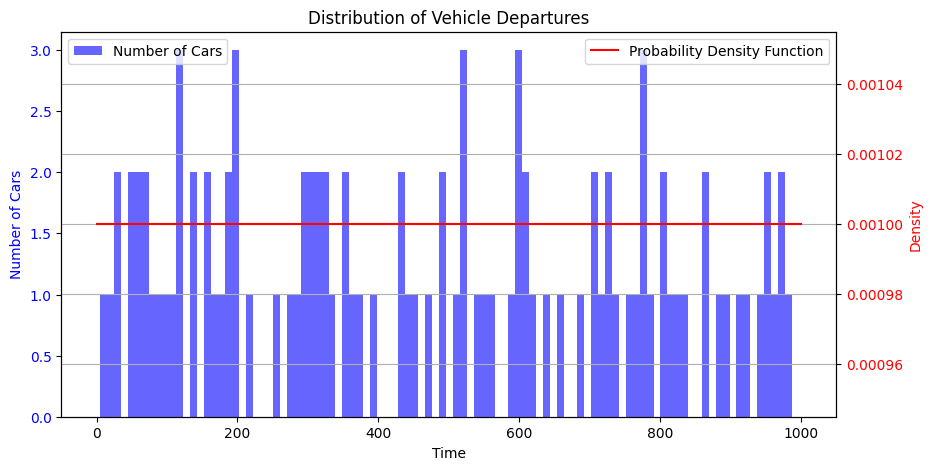

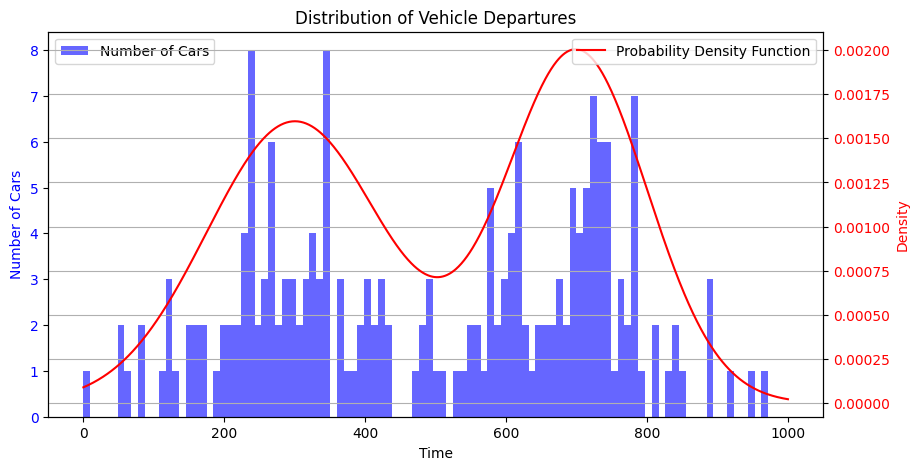

In [4]:
# create the simulation traffic

gen = TrafficGenerator(ROU_FILE, MAX_SIM_TIME, float(STEP_LENGTH), int(N_CARS / 2), seed, distribution="uniform")
gen.generate_routefile(plot_distribution=True)

gen = TrafficGenerator(ROU_FILE, MAX_SIM_TIME, float(STEP_LENGTH), N_CARS, seed, distribution="normal")
gen.generate_routefile(plot_distribution=True)

In [5]:
# Define the agent model
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(INPUT_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, ACTION_SIZE),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)
    
    def calc_loss(self, prev_log_prob, log_prob, advantage, epsilon):
        ratio = torch.exp(log_prob - prev_log_prob)
        ratioed_advantage = ratio * advantage
        clipped_advantage = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantage

        if advantage > 0:
            loss = -torch.min(ratioed_advantage, clipped_advantage)
        else:
            loss = -torch.max(ratioed_advantage, clipped_advantage)

        if DEBUG : print(f" ratio: {ratio.item():.3f} = {torch.exp(log_prob - prev_log_prob).item():.3f}, = exp({log_prob.item():.3f} - {prev_log_prob.item():.3f})")
        if DEBUG : print(f" clip: {clipped_advantage.item():.3f} = clamped({ratio.item():.3f}, 1-{epsilon}, 1+{epsilon}) * {advantage.item():.3f}")
        if DEBUG : print(f" loss: {loss.item():.3f} = -min({(ratio * advantage).item():.3f}, {clipped_advantage.item():.3f})")
    
        return loss
    
# Define the critic model
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(INPUT_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)
    
print("finished defining the actor and critic models")

finished defining the actor and critic models


In [6]:
import torch.nn.functional as F

def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

# Actor module, categorical actions only
class Actor_mish(nn.Module):
    def __init__(self, state_dim, n_actions, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            activation(),
            nn.Linear(256, 128),
            activation(),
            nn.Linear(128, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

# Critic module
class Critic_mish(nn.Module):
    def __init__(self, state_dim, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            activation(),
            nn.Linear(256, 128),
            activation(),
            nn.Linear(128, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [7]:
class Simulation:
    def __init__(self):
        self.vehicles_info = {}
        self.arrived_vehicles = 0
        self.total_waiting_time = 0
        self.avg_speed = 0
        self.epsilon = 0.2
        self.current_green_lane = None
        self.prev_green_lane = None
        self.prev_green_lane_duration = None

    def start(self, episode):
        try:
            
            if episode == 0: # human mode
                SUMO_APP = SUMO_GUI
                DELAY = "200"
            elif episode % EPISODES_GUI == 0:
                SUMO_APP = SUMO_GUI
                DELAY = "100"
            else:
                SUMO_APP = SUMO_HEADLESS
                DELAY = "0"

            SUMO_CMD = [SUMO_APP, "-c", CONFIG_FILE, "-g", GUI_SETTINGS_FILE, "--step-length", STEP_LENGTH ,"--delay", DELAY, "--time-to-teleport" , "-1", "--start", "--quit-on-end", "--keep-after-arrival", str(MAX_SIM_TIME) ]
            traci.start(SUMO_CMD)
        except Exception as e:
            print(f"Error starting simulation: {e}")
            traci.close()

    def close(self):
        traci.close()

    def calc_steps_to_advance(self, action_changed_phase):
        if action_changed_phase:
            time_to_step = 4 # 3 yellow + 1 green
        else:
            time_to_step = 4
            
        n_steps = int(time_to_step / float(STEP_LENGTH))
        return n_steps
    
    def advance(self, n_steps=1):
        for _ in range(n_steps):
            traci.simulationStep()
            self.arrived_vehicles += traci.simulation.getArrivedNumber()
            # store the vehicles info
            for vehicle_id in traci.vehicle.getIDList():
                distance_travelled = traci.vehicle.getDistance(vehicle_id)
                time_alive = traci.simulation.getTime() - traci.vehicle.getDeparture(vehicle_id)
                waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle_id)
                self.vehicles_info[vehicle_id] = [distance_travelled, time_alive, waiting_time]
                
    def get_state(self):
        lane_counter = [0, 0, 0, 0]
        state = np.zeros(MAX_STATE_SIZE)
        for vehicle_id in traci.vehicle.getIDList():
            upcoming_tls = traci.vehicle.getNextTLS(vehicle_id)
            if len(upcoming_tls) != 0:
                speed = traci.vehicle.getSpeed(vehicle_id)
                waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle_id)
                tl_id, tl_index, distance, tl_state = upcoming_tls[0]
                vehicle_state_index = lane_counter[tl_index]
                state[tl_index][vehicle_state_index] = [distance, speed, waiting_time, 0, 0]
                # state[tl_index][vehicle_state_index] = [distance, speed, waiting_time]
                lane_counter[tl_index] += 1
        # print(f"vehicles per lane: {lane_counter}")

        tl_id = traci.trafficlight.getIDList()[0]
        current_phase = traci.trafficlight.getPhase(tl_id)
        phase_duration = traci.trafficlight.getSpentDuration(tl_id)
        if (current_phase == 0 or current_phase == 3): # 0 has green or about to turn green
            green_lane = 0
            state[[0,2],:,3:] = [1, phase_duration]
            state[[1,3],:,3:] = [0, phase_duration]
        else:
            green_lane = 1
            state[[0,2],:,3:] = [0, phase_duration]
            state[[1,3],:,3:] = [1, phase_duration]

        # sort by distance, take only the first vehicles and flatten the state STATE_SIZE -> INPUT_SIZE
        state = np.round(np.flip(np.sort(state, axis=1), axis=1), 1)
        state = state[:, :STATE_SIZE[1], :]
        # print(state[:, :int(STATE_SIZE[1]/5), :])
        state = state.flatten()
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    
    def calc_reward(self):
        # choose the reward policy 
        reward_policy = "average_speed" # "waiting_time" or "average_speed" or "mixed"
        reward_alpha = 0.5
        
        # init parameters
        total_cars_in_simulation = traci.vehicle.getIDCount()
        car_speeds = []
        waiting_times = []

        # calculate the reward
        for vehicle_id in traci.vehicle.getIDList():
            car_speeds.append(traci.vehicle.getSpeed(vehicle_id))
            if traci.vehicle.getNextTLS(vehicle_id):
                waiting_times.append(traci.vehicle.getAccumulatedWaitingTime(vehicle_id))

        # print(f"car speeds: {car_speeds}", f"len: {len(car_speeds)}")
        # print(f"waiting times: {waiting_times}, len: {len(waiting_times)}")
        
        total_speed = sum(car_speeds)
        total_waiting_time = sum(waiting_times)

        avg_speed = 0 if len(car_speeds) == 0 else (total_speed / len(car_speeds))
        avg_waiting_time = 0 if len(waiting_times) == 0 else (total_waiting_time / len(waiting_times))

        speed_reward = 0
        for speed in car_speeds:
            if avg_speed > 1:
                if speed >= avg_speed:
                    speed_reward += 1
                else:
                    speed_reward -= 1
            else:
                speed_reward -= 1

        if (self.prev_green_lane_duration > 5 and speed_reward < 0 and self.prev_green_lane != self.current_green_lane):
            speed_reward = 100
        
        # simluation of mannyyyyyyyy cars
        # show that it gives only 1 lane green
        
        # calculate the reward based on the reward policy
        if reward_policy == "waiting_time":
            reward = -avg_waiting_time
        elif reward_policy == "average_speed":
            reward = avg_speed
        elif reward_policy == "mixed":
            reward = (reward_alpha * avg_speed) - ((1 - reward_alpha) * avg_waiting_time)
        
        return reward


    def perform_action(self, action):

        # maybe add epsilon greedy here ?
        # if (random.random() < self.epsilon):
        #     action = random.randint(0, 1)

        tl_id = traci.trafficlight.getIDList()[0]
        current_phase = traci.trafficlight.getPhase(tl_id)
        if (current_phase == 0 or current_phase == 3): # 0 has green or about to turn green
            current_green_lane = 0
        else:
            current_green_lane = 1

        switch_green_lane = (current_green_lane != action)

        if switch_green_lane:
            if current_green_lane == 0:
                new_phase = 1 # turn to yellow for lane 1
            else:
                new_phase = 3 # turn to yellow for lane 0
        else:
            new_phase = current_phase

        self.prev_green_lane = current_green_lane
        self.prev_green_lane_duration = traci.trafficlight.getSpentDuration(tl_id)
        self.current_green_lane = action

        traci.trafficlight.setPhase(tl_id, new_phase) # set again the same phase (to reset the duration)
        return switch_green_lane
    
    def print_results(self, episode):
        
        total_vehicles = self.arrived_vehicles
        total_sim_time = round(traci.simulation.getTime(), 1)
        vehicles_per_minute = round(total_vehicles / total_sim_time * 60, 2)
        total_waiting_time = sum(self.vehicles_info[vehicle_id][2] for vehicle_id in self.vehicles_info)

        # calc average speed of all cars (distance / time_alive)
        for vehicle_id in self.vehicles_info:
            dist = self.vehicles_info[vehicle_id][0]
            time_alive = self.vehicles_info[vehicle_id][1]
            avg_speed = dist / time_alive
            
        total_accumulated_avg_speed = sum(self.vehicles_info[vehicle_id][0] / self.vehicles_info[vehicle_id][1] for vehicle_id in self.vehicles_info)
        avg_speed = 0 if total_vehicles == 0 else (total_accumulated_avg_speed / total_vehicles)
        
        # store the results for plotting
        self.total_waiting_time = total_waiting_time
        self.avg_speed = avg_speed

        print(f"Episode {episode}: {total_vehicles} vehicles, {total_sim_time} seconds ({vehicles_per_minute} vehicles/min), total waiting time: {total_waiting_time}, average speed: {avg_speed:.2f}")

print("finished defining the simulation class")

finished defining the simulation class


In [8]:
# create the agent
# actor_relu = Actor()
# critic_relu = Critic()

actor_mish = Actor_mish(INPUT_SIZE, ACTION_SIZE, activation=Mish)
critic_mish = Critic_mish(INPUT_SIZE, activation=Mish)

actor = actor_mish # actor_relu
critic = critic_mish # critic_relu

# define hyperparameters
actor_adam_optimizer = optim.Adam(actor.parameters(), lr=1e-5) # optimizer for the actor
critic_adam_optimizer = optim.Adam(critic.parameters(), lr=1e-4) # optimizer for the critic
gamma = 0.99 # discount factor
exploration_epsilon = 0.2
clipping_epsilon = 0.1
loss_fn = nn.MSELoss() # loss function

# # make sure the actor gradients are not too high
clip_grad_norm_(actor.parameters(), max_norm=1.0)
clip_grad_norm_(critic.parameters(), max_norm=1.0)

print("finished creating the agent")

finished creating the agent


In [9]:
entopry_coef = 0.1

def policy_loss(old_log_prob, log_prob, entropy, advantage, eps):
    ratio = (log_prob - old_log_prob).exp()
    clipped = torch.clamp(ratio, 1-eps, 1+eps)*advantage
    
    min = torch.min(ratio*advantage, clipped)
    entropy_bonus = (entopry_coef * entropy).mean()
    loss = - (min + entropy_bonus)
    
    if DEBUG : print(f" ratio: {ratio.item():.3f} = {torch.exp(log_prob - old_log_prob).item():.3f}, = exp({log_prob.item():.3f} - {old_log_prob.item():.3f})")
    if DEBUG : print(f" clip: {clipped.item():.3f} = clamped({ratio.item():.3f}, 1-{eps}, 1+{eps}) * {advantage.item():.3f}")
    if DEBUG : print(f" min: {min.item():.3f}, entropy: {entropy_bonus.item():.3f}")
    if DEBUG : print(f" loss: {loss.item():.3f} = -min({(ratio * advantage).item():.3f}, {clipped.item():.3f})")
    
    return loss

import torch.nn.functional as F

Training Episodes:   0%|                                                                                                                                                                | 0/200 [00:00<?, ?it/s]

Starting episode 1
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   0%|▊                                                                                                                                                       | 1/200 [00:08<27:40,  8.35s/it]

Episode 1 finished

Episode 1: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1097.0, average speed: 8.23
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 2
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   1%|█▌                                                                                                                                                      | 2/200 [00:16<26:12,  7.94s/it]

Episode 2 finished

Episode 2: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1116.0, average speed: 8.20
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 3
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   2%|██▎                                                                                                                                                     | 3/200 [00:24<26:29,  8.07s/it]

Episode 3 finished

Episode 3: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 869.0, average speed: 8.26
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 4
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   2%|███                                                                                                                                                     | 4/200 [00:35<30:50,  9.44s/it]

Episode 4 finished

Episode 4: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1089.0, average speed: 8.31
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 5
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   2%|███▊                                                                                                                                                    | 5/200 [00:44<30:09,  9.28s/it]

Episode 5 finished

Episode 5: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1160.0, average speed: 8.15
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 6
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   3%|████▌                                                                                                                                                   | 6/200 [00:52<28:42,  8.88s/it]

Episode 6 finished

Episode 6: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 761.0, average speed: 8.41
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 7
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   4%|█████▎                                                                                                                                                  | 7/200 [01:00<27:36,  8.58s/it]

Episode 7 finished

Episode 7: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1076.0, average speed: 8.35
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 8
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   4%|██████                                                                                                                                                  | 8/200 [01:09<27:32,  8.61s/it]

Episode 8 finished

Episode 8: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 895.0, average speed: 8.42
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 9
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   4%|██████▊                                                                                                                                                 | 9/200 [01:17<26:36,  8.36s/it]

Episode 9 finished

Episode 9: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 963.0, average speed: 8.36
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 10
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   5%|███████▌                                                                                                                                               | 10/200 [01:25<25:50,  8.16s/it]

Episode 10 finished

Episode 10: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 882.0, average speed: 8.30
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 49ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 11
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   6%|████████▎                                                                                                                                              | 11/200 [01:33<26:15,  8.34s/it]

Episode 11 finished

Episode 11: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 922.0, average speed: 8.66
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 12
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   6%|█████████                                                                                                                                              | 12/200 [01:40<24:51,  7.94s/it]

Episode 12 finished

Episode 12: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 938.0, average speed: 8.69
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 13
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   6%|█████████▊                                                                                                                                             | 13/200 [01:49<25:11,  8.08s/it]

Episode 13 finished

Episode 13: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 983.0, average speed: 8.21
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 14
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   7%|██████████▌                                                                                                                                            | 14/200 [01:57<25:30,  8.23s/it]

Episode 14 finished

Episode 14: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 850.0, average speed: 8.55
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 15
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   8%|███████████▎                                                                                                                                           | 15/200 [02:07<26:39,  8.65s/it]

Episode 15 finished

Episode 15: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1545.0, average speed: 7.79
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 16
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   8%|████████████                                                                                                                                           | 16/200 [02:14<25:32,  8.33s/it]

Episode 16 finished

Episode 16: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 929.0, average speed: 8.17
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 17
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   8%|████████████▊                                                                                                                                          | 17/200 [02:23<25:58,  8.51s/it]

Episode 17 finished

Episode 17: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1469.0, average speed: 8.02
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 18
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:   9%|█████████████▌                                                                                                                                         | 18/200 [02:31<24:54,  8.21s/it]

Episode 18 finished

Episode 18: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 877.0, average speed: 8.16
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 19
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  10%|██████████████▎                                                                                                                                        | 19/200 [02:39<24:18,  8.06s/it]

Episode 19 finished

Episode 19: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1138.0, average speed: 7.96
Step #996.00 (1ms ~= 1000.00*RT, ~0.00UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)      
Starting episode 20
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  10%|███████████████                                                                                                                                        | 20/200 [02:47<24:46,  8.26s/it]

Episode 20 finished

Episode 20: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 904.0, average speed: 8.46
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 30ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 21
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  10%|███████████████▊                                                                                                                                       | 21/200 [02:56<24:54,  8.35s/it]

Episode 21 finished

Episode 21: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 2137.0, average speed: 7.47
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 22
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  11%|████████████████▌                                                                                                                                      | 22/200 [03:03<23:56,  8.07s/it]

Episode 22 finished

Episode 22: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1374.0, average speed: 8.02
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 23
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  12%|█████████████████▎                                                                                                                                     | 23/200 [03:11<23:52,  8.09s/it]

Episode 23 finished

Episode 23: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1605.0, average speed: 8.07
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 24
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  12%|██████████████████                                                                                                                                     | 24/200 [03:20<24:26,  8.33s/it]

Episode 24 finished

Episode 24: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1190.0, average speed: 7.89
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 25
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  12%|██████████████████▉                                                                                                                                    | 25/200 [03:30<25:07,  8.61s/it]

Episode 25 finished

Episode 25: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 800.0, average speed: 8.51
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 26
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  13%|███████████████████▋                                                                                                                                   | 26/200 [03:38<24:36,  8.49s/it]

Episode 26 finished

Episode 26: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1004.0, average speed: 8.44
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 27
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  14%|████████████████████▍                                                                                                                                  | 27/200 [03:47<25:14,  8.76s/it]

Episode 27 finished

Episode 27: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 929.0, average speed: 8.29
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 28
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  14%|█████████████████████▏                                                                                                                                 | 28/200 [03:56<25:13,  8.80s/it]

Episode 28 finished

Episode 28: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1011.0, average speed: 8.29
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 29
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  14%|█████████████████████▉                                                                                                                                 | 29/200 [04:04<23:57,  8.41s/it]

Episode 29 finished

Episode 29: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1261.0, average speed: 8.67
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 30
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  15%|██████████████████████▋                                                                                                                                | 30/200 [04:11<22:55,  8.09s/it]

Episode 30 finished

Episode 30: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 967.0, average speed: 8.41
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 32ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 31
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  16%|███████████████████████▍                                                                                                                               | 31/200 [04:18<21:55,  7.78s/it]

Episode 31 finished

Episode 31: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 939.0, average speed: 8.98
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 32
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  16%|████████████████████████▏                                                                                                                              | 32/200 [04:25<21:07,  7.55s/it]

Episode 32 finished

Episode 32: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 748.0, average speed: 8.73
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 33
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  16%|████████████████████████▉                                                                                                                              | 33/200 [04:32<20:50,  7.49s/it]

Episode 33 finished

Episode 33: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 887.0, average speed: 8.44
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 34
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  17%|█████████████████████████▋                                                                                                                             | 34/200 [04:39<20:24,  7.37s/it]

Episode 34 finished

Episode 34: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 988.0, average speed: 8.29
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 35
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  18%|██████████████████████████▍                                                                                                                            | 35/200 [04:48<20:51,  7.59s/it]

Episode 35 finished

Episode 35: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1825.0, average speed: 7.68
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 36
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  18%|███████████████████████████▏                                                                                                                           | 36/200 [04:56<21:07,  7.73s/it]

Episode 36 finished

Episode 36: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1064.0, average speed: 8.20
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 37
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  18%|███████████████████████████▉                                                                                                                           | 37/200 [05:05<22:01,  8.11s/it]

Episode 37 finished

Episode 37: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1519.0, average speed: 7.61
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 38
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  19%|████████████████████████████▋                                                                                                                          | 38/200 [05:13<21:49,  8.09s/it]

Episode 38 finished

Episode 38: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1020.0, average speed: 8.54
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 39
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  20%|█████████████████████████████▍                                                                                                                         | 39/200 [05:21<21:34,  8.04s/it]

Episode 39 finished

Episode 39: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1327.0, average speed: 7.80
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 40
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  20%|██████████████████████████████▏                                                                                                                        | 40/200 [05:28<20:55,  7.85s/it]

Episode 40 finished

Episode 40: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 843.0, average speed: 8.35
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 41
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  20%|██████████████████████████████▉                                                                                                                        | 41/200 [05:36<21:07,  7.97s/it]

Episode 41 finished

Episode 41: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1064.0, average speed: 8.49
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 42
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  21%|███████████████████████████████▋                                                                                                                       | 42/200 [05:44<20:59,  7.97s/it]

Episode 42 finished

Episode 42: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1581.0, average speed: 7.87
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 43
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  22%|████████████████████████████████▍                                                                                                                      | 43/200 [05:52<21:02,  8.04s/it]

Episode 43 finished

Episode 43: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1660.0, average speed: 7.93
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 44
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  22%|█████████████████████████████████▏                                                                                                                     | 44/200 [06:01<21:08,  8.13s/it]

Episode 44 finished

Episode 44: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 912.0, average speed: 8.36
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 45
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  22%|█████████████████████████████████▉                                                                                                                     | 45/200 [06:08<20:32,  7.95s/it]

Episode 45 finished

Episode 45: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1375.0, average speed: 8.25
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 46
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  23%|██████████████████████████████████▋                                                                                                                    | 46/200 [06:17<20:39,  8.05s/it]

Episode 46 finished

Episode 46: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 931.0, average speed: 8.62
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 47
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  24%|███████████████████████████████████▍                                                                                                                   | 47/200 [06:24<19:50,  7.78s/it]

Episode 47 finished

Episode 47: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1065.0, average speed: 8.04
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 48
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  24%|████████████████████████████████████▏                                                                                                                  | 48/200 [06:32<19:43,  7.78s/it]

Episode 48 finished

Episode 48: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 914.0, average speed: 8.68
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 49
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  24%|████████████████████████████████████▉                                                                                                                  | 49/200 [06:38<18:49,  7.48s/it]

Episode 49 finished

Episode 49: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 898.0, average speed: 8.13
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 50
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  25%|█████████████████████████████████████▊                                                                                                                 | 50/200 [06:46<18:49,  7.53s/it]

Episode 50 finished

Episode 50: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 980.0, average speed: 8.69
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 51
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  26%|██████████████████████████████████████▌                                                                                                                | 51/200 [06:55<19:30,  7.85s/it]

Episode 51 finished

Episode 51: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1381.0, average speed: 7.84
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 52
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  26%|███████████████████████████████████████▎                                                                                                               | 52/200 [07:02<18:42,  7.58s/it]

Episode 52 finished

Episode 52: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 976.0, average speed: 8.37
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 53
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  26%|████████████████████████████████████████                                                                                                               | 53/200 [07:09<18:19,  7.48s/it]

Episode 53 finished

Episode 53: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1037.0, average speed: 8.31
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 54
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  27%|████████████████████████████████████████▊                                                                                                              | 54/200 [07:17<18:24,  7.56s/it]

Episode 54 finished

Episode 54: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1000.0, average speed: 8.50
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 55
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  28%|█████████████████████████████████████████▌                                                                                                             | 55/200 [07:24<17:56,  7.42s/it]

Episode 55 finished

Episode 55: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1070.0, average speed: 8.19
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 56
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  28%|██████████████████████████████████████████▎                                                                                                            | 56/200 [07:32<18:31,  7.72s/it]

Episode 56 finished

Episode 56: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1253.0, average speed: 8.01
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 57
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  28%|███████████████████████████████████████████                                                                                                            | 57/200 [07:39<18:01,  7.57s/it]

Episode 57 finished

Episode 57: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1030.0, average speed: 8.31
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 58
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  29%|███████████████████████████████████████████▊                                                                                                           | 58/200 [07:47<18:04,  7.64s/it]

Episode 58 finished

Episode 58: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1137.0, average speed: 8.13
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 59
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  30%|████████████████████████████████████████████▌                                                                                                          | 59/200 [07:54<17:48,  7.58s/it]

Episode 59 finished

Episode 59: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1076.0, average speed: 8.16
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 60
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  30%|█████████████████████████████████████████████▎                                                                                                         | 60/200 [08:04<19:11,  8.23s/it]

Episode 60 finished

Episode 60: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1439.0, average speed: 7.57
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 27ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 61
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  30%|██████████████████████████████████████████████                                                                                                         | 61/200 [08:15<20:39,  8.91s/it]

Episode 61 finished

Episode 61: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1949.0, average speed: 7.52
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 62
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  31%|██████████████████████████████████████████████▊                                                                                                        | 62/200 [08:25<21:35,  9.39s/it]

Episode 62 finished

Episode 62: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1439.0, average speed: 8.06
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 63
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  32%|███████████████████████████████████████████████▌                                                                                                       | 63/200 [08:35<21:49,  9.56s/it]

Episode 63 finished

Episode 63: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1145.0, average speed: 7.74
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 64
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  32%|████████████████████████████████████████████████▎                                                                                                      | 64/200 [08:46<22:40, 10.00s/it]

Episode 64 finished

Episode 64: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1039.0, average speed: 8.12
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 30ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 65
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  32%|█████████████████████████████████████████████████                                                                                                      | 65/200 [08:55<21:39,  9.62s/it]

Episode 65 finished

Episode 65: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1139.0, average speed: 8.09
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 66
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  33%|█████████████████████████████████████████████████▊                                                                                                     | 66/200 [09:04<20:53,  9.35s/it]

Episode 66 finished

Episode 66: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1409.0, average speed: 7.92
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 67
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  34%|██████████████████████████████████████████████████▌                                                                                                    | 67/200 [09:12<20:13,  9.13s/it]

Episode 67 finished

Episode 67: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1389.0, average speed: 8.40
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 68
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  34%|███████████████████████████████████████████████████▎                                                                                                   | 68/200 [09:21<19:30,  8.86s/it]

Episode 68 finished

Episode 68: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 671.0, average speed: 8.85
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 69
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  34%|████████████████████████████████████████████████████                                                                                                   | 69/200 [09:29<19:15,  8.82s/it]

Episode 69 finished

Episode 69: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 883.0, average speed: 8.64
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 70
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  35%|████████████████████████████████████████████████████▊                                                                                                  | 70/200 [09:39<19:25,  8.97s/it]

Episode 70 finished

Episode 70: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1004.0, average speed: 8.18
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 47ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 71
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 71/200 [09:50<20:34,  9.57s/it]

Episode 71 finished

Episode 71: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1146.0, average speed: 8.31
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 72
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  36%|██████████████████████████████████████████████████████▎                                                                                                | 72/200 [09:59<20:16,  9.50s/it]

Episode 72 finished

Episode 72: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 900.0, average speed: 8.24
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 73
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  36%|███████████████████████████████████████████████████████                                                                                                | 73/200 [10:10<21:04,  9.96s/it]

Episode 73 finished

Episode 73: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1712.0, average speed: 7.70
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 74
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  37%|███████████████████████████████████████████████████████▊                                                                                               | 74/200 [10:17<19:16,  9.18s/it]

Episode 74 finished

Episode 74: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 883.0, average speed: 8.28
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 75
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  38%|████████████████████████████████████████████████████████▋                                                                                              | 75/200 [10:26<19:01,  9.13s/it]

Episode 75 finished

Episode 75: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1055.0, average speed: 8.03
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 76
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 76/200 [10:39<21:04, 10.20s/it]

Episode 76 finished

Episode 76: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1820.0, average speed: 7.60
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 39ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 77
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 77/200 [10:50<21:08, 10.31s/it]

Episode 77 finished

Episode 77: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1254.0, average speed: 8.16
Step #996.00 (1ms ~= 1000.00*RT, ~0.00UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)      
Starting episode 78
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 78/200 [10:59<20:42, 10.18s/it]

Episode 78 finished

Episode 78: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1076.0, average speed: 8.15
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 79
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 79/200 [11:08<19:16,  9.56s/it]

Episode 79 finished

Episode 79: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1649.0, average speed: 7.94
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 80
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 80/200 [11:15<17:54,  8.95s/it]

Episode 80 finished

Episode 80: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1252.0, average speed: 7.98
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 28ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 81
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 81/200 [11:26<19:08,  9.65s/it]

Episode 81 finished

Episode 81: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1174.0, average speed: 8.11
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 82
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 82/200 [11:40<21:15, 10.81s/it]

Episode 82 finished

Episode 82: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1631.0, average speed: 8.09
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 83
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 83/200 [11:53<22:40, 11.63s/it]

Episode 83 finished

Episode 83: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1882.0, average speed: 7.64
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 51ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 84
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 84/200 [12:06<22:58, 11.89s/it]

Episode 84 finished

Episode 84: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1732.0, average speed: 7.88
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 48ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 85
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 85/200 [12:19<23:23, 12.21s/it]

Episode 85 finished

Episode 85: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1362.0, average speed: 8.08
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 86
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 86/200 [12:31<23:25, 12.33s/it]

Episode 86 finished

Episode 86: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1436.0, average speed: 7.79
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 87
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 87/200 [12:43<22:57, 12.19s/it]

Episode 87 finished

Episode 87: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1392.0, average speed: 7.97
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 88
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 88/200 [12:54<21:57, 11.76s/it]

Episode 88 finished

Episode 88: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 952.0, average speed: 8.44
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 89
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 89/200 [13:04<20:58, 11.34s/it]

Episode 89 finished

Episode 89: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1362.0, average speed: 7.69
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 90
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 90/200 [13:14<19:59, 10.90s/it]

Episode 90 finished

Episode 90: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1079.0, average speed: 8.11
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 40ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 91
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 91/200 [13:26<20:09, 11.10s/it]

Episode 91 finished

Episode 91: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1309.0, average speed: 7.93
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 92
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 92/200 [13:36<19:18, 10.72s/it]

Episode 92 finished

Episode 92: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1491.0, average speed: 7.88
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 93
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 93/200 [13:45<18:21, 10.29s/it]

Episode 93 finished

Episode 93: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1158.0, average speed: 8.66
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 94
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 94/200 [13:54<17:40, 10.01s/it]

Episode 94 finished

Episode 94: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 847.0, average speed: 8.56
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 95
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 95/200 [14:03<16:48,  9.61s/it]

Episode 95 finished

Episode 95: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1136.0, average speed: 8.30
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 96
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 96/200 [14:13<16:39,  9.61s/it]

Episode 96 finished

Episode 96: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 641.0, average speed: 8.78
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 97
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 97/200 [14:23<17:00,  9.91s/it]

Episode 97 finished

Episode 97: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1120.0, average speed: 8.28
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 98
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 98/200 [14:35<17:34, 10.34s/it]

Episode 98 finished

Episode 98: 180 vehicles, 1000.0 seconds (10.8 vehicles/min), total waiting time: 3151.0, average speed: 8.30
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 32ms, vehicles TOT 198 ACT 18 BUF 2)                 
Starting episode 99
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 99/200 [14:42<16:03,  9.54s/it]

Episode 99 finished

Episode 99: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1323.0, average speed: 7.99
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 100
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 100/200 [14:51<15:19,  9.20s/it]

Episode 100 finished

Episode 100: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1480.0, average speed: 8.24
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 101
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                          | 101/200 [15:00<15:03,  9.13s/it]

Episode 101 finished

Episode 101: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1511.0, average speed: 8.13
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 102
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 102/200 [15:08<14:19,  8.77s/it]

Episode 102 finished

Episode 102: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1805.0, average speed: 8.15
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 103
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  52%|█████████████████████████████████████████████████████████████████████████████▎                                                                        | 103/200 [15:15<13:39,  8.45s/it]

Episode 103 finished

Episode 103: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 995.0, average speed: 8.28
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 104
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 104/200 [15:23<12:58,  8.11s/it]

Episode 104 finished

Episode 104: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1049.0, average speed: 8.47
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 105
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                       | 105/200 [15:31<12:51,  8.13s/it]

Episode 105 finished

Episode 105: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1569.0, average speed: 7.75
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 106
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 106/200 [15:38<12:33,  8.01s/it]

Episode 106 finished

Episode 106: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1032.0, average speed: 8.50
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 107
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  54%|████████████████████████████████████████████████████████████████████████████████▎                                                                     | 107/200 [15:49<13:42,  8.85s/it]

Episode 107 finished

Episode 107: 184 vehicles, 1000.0 seconds (11.04 vehicles/min), total waiting time: 3451.0, average speed: 8.24
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 26ms, vehicles TOT 200 ACT 16 BUF 0)                 
Starting episode 108
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 108/200 [16:02<15:32, 10.14s/it]

Episode 108 finished

Episode 108: 177 vehicles, 1000.0 seconds (10.62 vehicles/min), total waiting time: 3824.0, average speed: 8.16
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 26ms, vehicles TOT 195 ACT 18 BUF 5)                 
Starting episode 109
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                    | 109/200 [16:15<16:20, 10.78s/it]

Episode 109 finished

Episode 109: 174 vehicles, 1000.0 seconds (10.44 vehicles/min), total waiting time: 3610.0, average speed: 8.72
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 194 ACT 20 BUF 6)                 
Starting episode 110
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 110/200 [16:26<16:26, 10.96s/it]

Episode 110 finished

Episode 110: 183 vehicles, 1000.0 seconds (10.98 vehicles/min), total waiting time: 2517.0, average speed: 8.95
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 50ms, vehicles TOT 200 ACT 17 BUF 0)                 
Starting episode 111
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                  | 111/200 [16:39<17:08, 11.55s/it]

Episode 111 finished

Episode 111: 166 vehicles, 1000.0 seconds (9.96 vehicles/min), total waiting time: 3433.0, average speed: 8.74
Step #1000.00 (1ms ~= 1000.00*RT, ~23000.00UPS, TraCI: 36ms, vehicles TOT 189 ACT 23 BUF 11
Starting episode 112
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 112/200 [16:47<15:19, 10.45s/it]

Episode 112 finished

Episode 112: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1812.0, average speed: 7.89
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 113
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 113/200 [16:55<14:05,  9.71s/it]

Episode 113 finished

Episode 113: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1666.0, average speed: 8.23
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 114
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 114/200 [17:02<12:53,  8.99s/it]

Episode 114 finished

Episode 114: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1053.0, average speed: 8.39
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 115
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                               | 115/200 [17:11<12:39,  8.93s/it]

Episode 115 finished

Episode 115: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1829.0, average speed: 7.77
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 116
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 116/200 [17:19<12:05,  8.63s/it]

Episode 116 finished

Episode 116: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1650.0, average speed: 7.68
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 117
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                              | 117/200 [17:29<12:24,  8.97s/it]

Episode 117 finished

Episode 117: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 2804.0, average speed: 6.94
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 118
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 118/200 [17:36<11:39,  8.53s/it]

Episode 118 finished

Episode 118: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1222.0, average speed: 8.06
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 119
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 119/200 [17:44<11:16,  8.35s/it]

Episode 119 finished

Episode 119: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1217.0, average speed: 8.14
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 120
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 120/200 [17:51<10:43,  8.04s/it]

Episode 120 finished

Episode 120: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 795.0, average speed: 8.71
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 121
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 121/200 [18:01<11:04,  8.41s/it]

Episode 121 finished

Episode 121: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 2037.0, average speed: 8.12
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 122
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 122/200 [18:10<11:14,  8.65s/it]

Episode 122 finished

Episode 122: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1627.0, average speed: 7.97
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 123
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 123/200 [18:21<11:57,  9.32s/it]

Episode 123 finished

Episode 123: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1386.0, average speed: 7.85
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 124
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 124/200 [18:31<11:59,  9.46s/it]

Episode 124 finished

Episode 124: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1716.0, average speed: 7.93
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 125
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 125/200 [18:39<11:17,  9.03s/it]

Episode 125 finished

Episode 125: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1519.0, average speed: 8.09
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 126
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 126/200 [18:47<11:02,  8.95s/it]

Episode 126 finished

Episode 126: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1084.0, average speed: 8.30
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 127
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 127/200 [18:55<10:26,  8.58s/it]

Episode 127 finished

Episode 127: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1002.0, average speed: 7.97
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 128
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 128/200 [19:04<10:30,  8.75s/it]

Episode 128 finished

Episode 128: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 954.0, average speed: 8.74
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 129
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 129/200 [19:11<09:42,  8.20s/it]

Episode 129 finished

Episode 129: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 934.0, average speed: 8.70
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 130
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 130/200 [19:20<09:40,  8.30s/it]

Episode 130 finished

Episode 130: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 2191.0, average speed: 7.48
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 131
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 131/200 [19:27<09:18,  8.09s/it]

Episode 131 finished

Episode 131: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1091.0, average speed: 8.18
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 132
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 132/200 [19:34<08:44,  7.71s/it]

Episode 132 finished

Episode 132: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 976.0, average speed: 8.43
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 133
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 133/200 [19:42<08:41,  7.78s/it]

Episode 133 finished

Episode 133: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1041.0, average speed: 8.17
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 134
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 134/200 [19:51<08:50,  8.04s/it]

Episode 134 finished

Episode 134: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1202.0, average speed: 8.06
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 135
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 135/200 [19:59<08:46,  8.09s/it]

Episode 135 finished

Episode 135: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1044.0, average speed: 8.35
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 136
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 136/200 [20:16<11:23, 10.68s/it]

Episode 136 finished

Episode 136: 157 vehicles, 1000.0 seconds (9.42 vehicles/min), total waiting time: 4554.0, average speed: 8.85
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 181 ACT 24 BUF 19)                
Starting episode 137
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 137/200 [20:25<10:45, 10.24s/it]

Episode 137 finished

Episode 137: 193 vehicles, 1000.0 seconds (11.58 vehicles/min), total waiting time: 2923.0, average speed: 7.79
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 200 ACT 7 BUF 0)                  
Starting episode 138
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 138/200 [20:35<10:26, 10.11s/it]

Episode 138 finished

Episode 138: 181 vehicles, 1000.0 seconds (10.86 vehicles/min), total waiting time: 2570.0, average speed: 9.32
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 200 ACT 19 BUF 0)                 
Starting episode 139
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 139/200 [20:43<09:51,  9.70s/it]

Episode 139 finished

Episode 139: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 2304.0, average speed: 8.34
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 140
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 140/200 [20:51<09:11,  9.19s/it]

Episode 140 finished

Episode 140: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1177.0, average speed: 8.13
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 141
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 141/200 [20:59<08:32,  8.68s/it]

Episode 141 finished

Episode 141: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1121.0, average speed: 8.23
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 142
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 142/200 [21:07<08:09,  8.43s/it]

Episode 142 finished

Episode 142: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1543.0, average speed: 7.69
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 143
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 143/200 [21:15<07:55,  8.34s/it]

Episode 143 finished

Episode 143: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1968.0, average speed: 7.40
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 144
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 144/200 [21:23<07:36,  8.16s/it]

Episode 144 finished

Episode 144: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1316.0, average speed: 7.97
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 145
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 145/200 [21:31<07:26,  8.11s/it]

Episode 145 finished

Episode 145: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 896.0, average speed: 8.53
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 146
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 146/200 [21:39<07:20,  8.15s/it]

Episode 146 finished

Episode 146: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1507.0, average speed: 7.79
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 147
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 147/200 [21:47<07:13,  8.18s/it]

Episode 147 finished

Episode 147: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1503.0, average speed: 8.20
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 148
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 148/200 [21:55<07:06,  8.21s/it]

Episode 148 finished

Episode 148: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1429.0, average speed: 8.20
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 149
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 149/200 [22:03<06:54,  8.13s/it]

Episode 149 finished

Episode 149: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1782.0, average speed: 7.49
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 150
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 150/200 [22:11<06:34,  7.90s/it]

Episode 150 finished

Episode 150: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1489.0, average speed: 8.13
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 28ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 151
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 151/200 [22:18<06:17,  7.71s/it]

Episode 151 finished

Episode 151: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1197.0, average speed: 8.13
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 152
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 152/200 [22:26<06:16,  7.83s/it]

Episode 152 finished

Episode 152: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1485.0, average speed: 7.70
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 153
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 153/200 [22:35<06:19,  8.08s/it]

Episode 153 finished

Episode 153: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 811.0, average speed: 8.48
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 154
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 154/200 [22:42<06:02,  7.88s/it]

Episode 154 finished

Episode 154: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1463.0, average speed: 7.88
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 155
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 155/200 [22:50<05:53,  7.85s/it]

Episode 155 finished

Episode 155: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1826.0, average speed: 7.58
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 156
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 156/200 [23:01<06:27,  8.80s/it]

Episode 156 finished

Episode 156: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 2356.0, average speed: 7.35
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 157
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 157/200 [23:10<06:24,  8.95s/it]

Episode 157 finished

Episode 157: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1138.0, average speed: 7.96
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 158
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 158/200 [23:18<06:02,  8.62s/it]

Episode 158 finished

Episode 158: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1130.0, average speed: 8.58
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 159
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 159/200 [23:25<05:34,  8.15s/it]

Episode 159 finished

Episode 159: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 924.0, average speed: 8.56
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 160
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 160/200 [23:33<05:16,  7.92s/it]

Episode 160 finished

Episode 160: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1053.0, average speed: 8.05
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 161
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 161/200 [23:40<05:04,  7.80s/it]

Episode 161 finished

Episode 161: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 939.0, average speed: 8.14
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 162
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 162/200 [23:48<04:58,  7.85s/it]

Episode 162 finished

Episode 162: 198 vehicles, 1000.0 seconds (11.88 vehicles/min), total waiting time: 1338.0, average speed: 8.59
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 2 BUF 0)                   
Starting episode 163
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 163/200 [23:56<04:51,  7.89s/it]

Episode 163 finished

Episode 163: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1061.0, average speed: 8.36
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 164
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 164/200 [24:04<04:47,  7.98s/it]

Episode 164 finished

Episode 164: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 997.0, average speed: 8.35
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 165
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 165/200 [24:13<04:52,  8.35s/it]

Episode 165 finished

Episode 165: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1421.0, average speed: 8.39
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 166
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 166/200 [24:22<04:47,  8.46s/it]

Episode 166 finished

Episode 166: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1073.0, average speed: 8.06
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 167
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 167/200 [24:32<04:48,  8.75s/it]

Episode 167 finished

Episode 167: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1035.0, average speed: 8.45
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 168
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 168/200 [24:40<04:38,  8.69s/it]

Episode 168 finished

Episode 168: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 995.0, average speed: 8.09
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 169
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 169/200 [24:49<04:35,  8.88s/it]

Episode 169 finished

Episode 169: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1023.0, average speed: 8.30
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 170
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 170/200 [25:02<05:03, 10.10s/it]

Episode 170 finished

Episode 170: 185 vehicles, 1000.0 seconds (11.1 vehicles/min), total waiting time: 3289.0, average speed: 8.20
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 46ms, vehicles TOT 200 ACT 15 BUF 0)                 
Starting episode 171
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 171/200 [25:14<05:09, 10.68s/it]

Episode 171 finished

Episode 171: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1009.0, average speed: 8.12
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 172
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 172/200 [25:25<04:58, 10.67s/it]

Episode 172 finished

Episode 172: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1272.0, average speed: 8.03
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 173
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 173/200 [25:35<04:41, 10.41s/it]

Episode 173 finished

Episode 173: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1530.0, average speed: 7.96
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 174
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 174/200 [25:45<04:25, 10.22s/it]

Episode 174 finished

Episode 174: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1295.0, average speed: 8.06
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 175
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 175/200 [25:56<04:27, 10.69s/it]

Episode 175 finished

Episode 175: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1716.0, average speed: 7.49
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 176
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 176/200 [26:06<04:07, 10.32s/it]

Episode 176 finished

Episode 176: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1255.0, average speed: 7.98
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 177
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 177/200 [26:14<03:39,  9.56s/it]

Episode 177 finished

Episode 177: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1051.0, average speed: 8.24
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 178
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 178/200 [26:21<03:18,  9.04s/it]

Episode 178 finished

Episode 178: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 989.0, average speed: 8.36
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 179
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 179/200 [26:30<03:09,  9.00s/it]

Episode 179 finished

Episode 179: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1421.0, average speed: 8.02
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 180
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 180/200 [26:41<03:07,  9.39s/it]

Episode 180 finished

Episode 180: 187 vehicles, 1000.0 seconds (11.22 vehicles/min), total waiting time: 3043.0, average speed: 8.42
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 45ms, vehicles TOT 200 ACT 13 BUF 0)                 
Starting episode 181
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 181/200 [26:50<02:59,  9.43s/it]

Episode 181 finished

Episode 181: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 2262.0, average speed: 7.86
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 182
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 182/200 [27:00<02:49,  9.40s/it]

Episode 182 finished

Episode 182: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1420.0, average speed: 7.72
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 183
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 183/200 [27:10<02:43,  9.64s/it]

Episode 183 finished

Episode 183: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1801.0, average speed: 8.26
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 200 ACT 1 BUF 0)                  
Starting episode 184
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 184/200 [27:24<02:54, 10.89s/it]

Episode 184 finished

Episode 184: 175 vehicles, 1000.0 seconds (10.5 vehicles/min), total waiting time: 3977.0, average speed: 8.40
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 194 ACT 19 BUF 6)                 
Starting episode 185
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 185/200 [27:33<02:36, 10.46s/it]

Episode 185 finished

Episode 185: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1607.0, average speed: 7.59
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 186
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 186/200 [27:41<02:17,  9.86s/it]

Episode 186 finished

Episode 186: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1496.0, average speed: 7.85
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 187
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 187/200 [27:49<01:58,  9.11s/it]

Episode 187 finished

Episode 187: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 997.0, average speed: 8.50
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 188
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 188/200 [27:56<01:42,  8.53s/it]

Episode 188 finished

Episode 188: 197 vehicles, 1000.0 seconds (11.82 vehicles/min), total waiting time: 1045.0, average speed: 8.34
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 200 ACT 3 BUF 0)                  
Starting episode 189
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 189/200 [28:04<01:32,  8.37s/it]

Episode 189 finished

Episode 189: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1672.0, average speed: 8.55
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 190
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 190/200 [28:16<01:34,  9.41s/it]

Episode 190 finished

Episode 190: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1266.0, average speed: 8.20
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 59ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 191
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 191/200 [28:28<01:33, 10.39s/it]

Episode 191 finished

Episode 191: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1042.0, average speed: 8.26
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 192
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 192/200 [28:39<01:24, 10.54s/it]

Episode 192 finished

Episode 192: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1322.0, average speed: 8.21
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 200 ACT 0 BUF 0)                  
Starting episode 193
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 193/200 [28:49<01:11, 10.16s/it]

Episode 193 finished

Episode 193: 200 vehicles, 992.0 seconds (12.1 vehicles/min), total waiting time: 1113.0, average speed: 8.28
Step #992.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 194
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 194/200 [28:58<01:00, 10.01s/it]

Episode 194 finished

Episode 194: 199 vehicles, 1000.0 seconds (11.94 vehicles/min), total waiting time: 1034.0, average speed: 8.36
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 1 BUF 0)                   
Starting episode 195
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 195/200 [29:06<00:47,  9.41s/it]

Episode 195 finished

Episode 195: 200 vehicles, 996.0 seconds (12.05 vehicles/min), total waiting time: 1632.0, average speed: 7.88
Step #996.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 196
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 196/200 [29:16<00:37,  9.37s/it]

Episode 196 finished

Episode 196: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1636.0, average speed: 7.81
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 197
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 197/200 [29:29<00:32, 10.72s/it]

Episode 197 finished

Episode 197: 171 vehicles, 1000.0 seconds (10.26 vehicles/min), total waiting time: 4240.0, average speed: 8.73
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 193 ACT 22 BUF 7)                 
Starting episode 198
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 198/200 [29:38<00:20, 10.04s/it]

Episode 198 finished

Episode 198: 200 vehicles, 1000.0 seconds (12.0 vehicles/min), total waiting time: 1049.0, average speed: 8.44
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 200 ACT 0 BUF 0)                   
Starting episode 199
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training Episodes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 199/200 [29:50<00:10, 10.62s/it]

Episode 199 finished

Episode 199: 174 vehicles, 1000.0 seconds (10.44 vehicles/min), total waiting time: 3783.0, average speed: 8.95
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 30ms, vehicles TOT 193 ACT 19 BUF 7)                 
Starting episode 200
 Retrying in 1 seconds


/home/aripomer/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Action: 1 , Prob: [[0.5145 0.4855]], Prob log: -0.72
Advantage: 13.85 = reward: 10.98 , critic_next_state: 8.17 , critic_state: 5.22
Action: 1 , Prob: [[0.4814 0.5186]], Prob log: -0.66
Advantage: 14.66 = reward: 14.46 , critic_next_state: 8.45 , critic_state: 8.17
 ratio: 1.068 = 1.068, = exp(-0.657 - -0.723)
 clip: 15.658 = clamped(1.068, 1-0.1, 1+0.1) * 14.658
 min: 15.658, entropy: 0.069
 loss: -15.727 = -min(15.658, 15.658)
actor_loss: -15.727 = --0.657 * 14.658
probs: [[0.4814 0.5186]]


Action: 1 , Prob: [[0.4299 0.5701]], Prob log: -0.56
Advantage: 0.08 = reward: 0.00 , critic_next_state: 8.62 , critic_state: 8.45
 ratio: 1.099 = 1.099, = exp(-0.562 - -0.657)
 clip: 0.092 = clamped(1.099, 1-0.1, 1+0.1) * 0.084
 min: 0.092, entropy: 0.068
 loss: -0.161 = -min(0.092, 0.092)
actor_loss: -0.161 = --0.562 * 0.084
probs: [[0.4299 0.5701]]


Action: 1 , Prob: [[0.3659 0.6341]], Prob log: -0.46
Advantage: 15.51 = reward: 13.05 , critic_next_state: 11.18 , critic_state: 8.61
 ratio: 1.1

Training Episodes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [31:27<00:00,  9.44s/it]


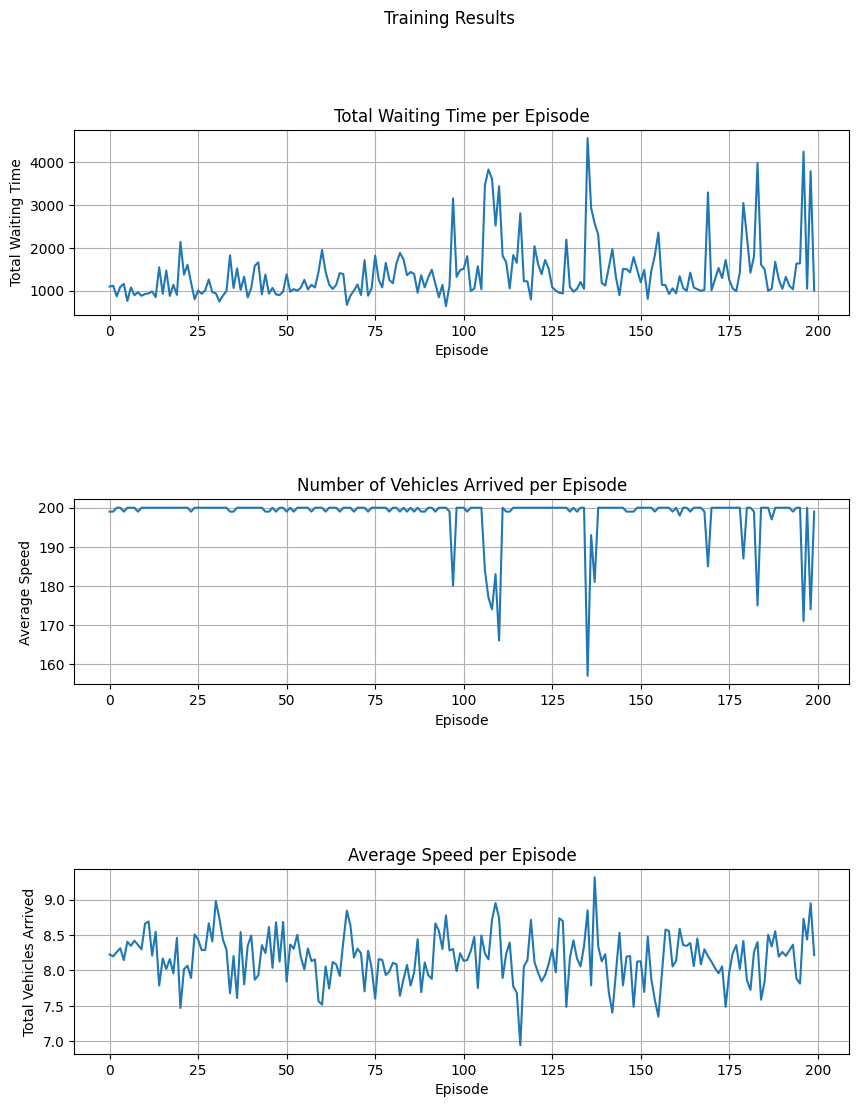

In [10]:
# %%script echo "Skip the training loop"

# actor.load_state_dict(torch.load("model_checkpoints/actor_weights_100.pth"))
# critic.load_state_dict(torch.load("model_checkpoints/critic_weights_100.pth"))

# store for each action all its probabilities
file = open('probs_history.csv', 'w', newline='')
writer = csv.writer(file)
writer.writerow(['episode', 'action', 'step', 'prob0', 'prob1'])

episodes_data = EpisodesData()

for episode in tqdm(range(1, EPISODES + 1), desc="Training Episodes"):
    tqdm.write(f"Starting episode {episode}")
    
    simulation = Simulation()
    simulation.start(episode)

    prev_prob_act_log = 0
    action = 0
    state = np.zeros(STATE_SIZE).flatten()
    state = torch.tensor(state ,dtype=torch.float32).unsqueeze(0)
    DEBUG = True if episode % EPISODES_GUI == 0 else False

    step = 0
    while traci.simulation.getMinExpectedNumber() > 0 and step < MAX_STEPS:

        yellow_phase = 'y' in traci.trafficlight.getRedYellowGreenState(traci.trafficlight.getIDList()[0])
        yellow_phase = False    
        any_cars_in_traffic = sum(bool(traci.vehicle.getNextTLS(v)) for v in traci.vehicle.getIDList())
        # training_step = (step % TRAIN_MODEL_STEPS_SIZE == 0) and (not yellow_phase) and any_cars_in_traffic
        any_Cars_in_simulation = traci.vehicle.getIDCount()
        training_step = any_Cars_in_simulation

        if (training_step):
            random_action = random.random() < exploration_epsilon
            if random_action: # exploration move
                action = torch.randint(0, ACTION_SIZE, (1,))
                probs = torch.ones(ACTION_SIZE) / ACTION_SIZE
                prob_act_log = torch.log(torch.tensor(1.0 / ACTION_SIZE, requires_grad=True))
                entropy = torch.tensor(1.0 / ACTION_SIZE) * torch.log(torch.tensor(1.0 / ACTION_SIZE))
            else: # use the actor to predict the action
                probs = actor(state)
                dist = torch.distributions.Categorical(probs = probs)
                action = dist.sample()
                prob_act_log = dist.log_prob(action)
                entropy = dist.entropy()
                if episode % 10 == 0:
                    probs_list = probs.detach().numpy()[0]
                    writer.writerow([episode, action.item(), step, probs_list[0], probs_list[1]])

            action = action.item()
            is_random = "random" if random_action else ""
            if DEBUG : print(f"Action: {action} {is_random}, Prob: {probs.detach().numpy()}, Prob log: {prob_act_log.item():.2f}")
            
        # advance the simulation
        action_changed_phase = simulation.perform_action(action)
        n_steps = simulation.calc_steps_to_advance(action_changed_phase)
        simulation.advance(n_steps)
        step += n_steps

        if (training_step):
            # get the next state and calculate the reward
            next_state = simulation.get_state()
            reward = simulation.calc_reward()
            critic_state = critic(state)
            critic_next_state = critic(next_state)
            advantage = reward + (gamma * critic_next_state - critic_state)
            if DEBUG : print(f"Advantage: {advantage.item():.2f} = reward: {reward:.2f} , critic_next_state: {critic_next_state.item():.2f} , critic_state: {critic_state.item():.2f}")

            prev_state = state
            state = next_state

            if prev_prob_act_log :
                # train the actor if the action taken was not a random exploration action
                if True:
                    actor_loss = policy_loss(prev_prob_act_log.detach(), prob_act_log, entropy, advantage.detach(), clipping_epsilon)
                    # actor_loss = actor.calc_loss(prev_prob_act_log.detach(), prob_act_log, advantage.detach(), clipping_epsilon)
                    # actor_loss = policy_loss_KL(advantage.detach(), clipping_epsilon, probs, action)
                    # actor_loss = -prob_act_log * advantage.detach()
                    if DEBUG : print(f"actor_loss: {actor_loss.item():.3f} = -{prob_act_log.item():.3f} * {advantage.item():.3f}")
                    actor_adam_optimizer.zero_grad()
                    actor_loss.backward()
                    actor_adam_optimizer.step()

                    with torch.no_grad():
                        probs = actor(prev_state)
                        if DEBUG : print(f"probs: {probs.detach().numpy()}\n\n")
                        # if DEBUG:
                        #     for param in actor.parameters():
                        #         if param.grad is not None:  # Ensure the gradient exists
                        #             print(param.grad)

                # train the critic
                critic_loss = advantage.abs().mean()
                critic_adam_optimizer.zero_grad()   
                critic_loss.backward()
                critic_adam_optimizer.step()

            prev_prob_act_log = prob_act_log       

    print(f"Episode {episode} finished\n")
    
    if (episode % 10 == 0):
        torch.save(actor.state_dict(), f"model_checkpoints/actor_weights_{episode}_mixed.pth")
        torch.save(critic.state_dict(), f"model_checkpoints/critic_weights_{episode}_mixed.pth")

    simulation.print_results(episode)
    episodes_data.add_episode_data(simulation)
    simulation.close()

episodes_data.plot_training_results()
file.close()

In [11]:
%%script echo "Skip the testing loop"

episodes_data = EpisodesData()

# Load the model in evaluation mode
actor.load_state_dict(torch.load("model_checkpoints/actor_weights_40.pth"))
actor.eval()

SUMO_APP = SUMO_GUI # SUMO_GUI or SUMO_HEADLESS
DELAY = "1000"
SUMO_CMD = [SUMO_APP, "-c", CONFIG_FILE, "-g", GUI_SETTINGS_FILE, "--step-length", STEP_LENGTH ,"--delay", DELAY, "--start", "--quit-on-end"]

simulation = Simulation()
simulation.start(0)

state = np.zeros(STATE_SIZE).flatten()
state = torch.tensor(state ,dtype=torch.float32).unsqueeze(0)

step = 0
while traci.simulation.getMinExpectedNumber() > 0 and step < MAX_STEPS:

    if (step % TRAIN_MODEL_STEPS_SIZE == 0):
        with torch.no_grad():
            # Use the actor to predict action probabilities
            probs = actor(state)
            dist = torch.distributions.Categorical(probs = probs) # Categorical distribution object
            action = dist.sample() # Sample an action from the distribution
            prob_act_log = dist.log_prob(action)
            action = action.item()
            # print the distribution and the action
            print(f"Action: {action}, Prob: {probs.detach().numpy()}")
            
            # perform the action
            simulation.perform_action(action)
    
    # advance the simulation
    traci.simulationStep()
    next_state = simulation.get_state()

    if (step % TRAIN_MODEL_STEPS_SIZE == 0):
        state = next_state

    # increment the step count     
    step += 1

simulation.print_results(episode)
episodes_data.add_episode_data(simulation)
simulation.close()

Skip the testing loop


In [12]:
%%script echo "Skip the simulation without the model"

# run the simulation without the model

simulation = Simulation()
simulation.start(0)

step = 0
while traci.simulation.getMinExpectedNumber() > 0 and step < MAX_STEPS:
    simulation.advance(1)
    step += 1

simulation.print_results(0)
simulation.close()

Skip the simulation without the model


In [13]:
%%script echo "Skip the human controlled simulation"

user_input = threading.Event()
stop_input_thread = False

def wait_for_input():
    global stop_input_thread
    while not stop_input_thread:
        input("Press Enter to switch the lights phase")
        user_input.set()

# Start a separate thread to handle user input
human_control_thread = threading.Thread(target=wait_for_input, daemon=True)
human_control_thread.start()

Simulation = Simulation()
Simulation.start(0)

# add arrow image to the simulation
img_id = "arrow_img"
traci.poi.add(img_id, 50, 50, (255, 0, 0, 255), layer=340, width=20, height=20, imgFile="right_left.png")

tl_id = traci.trafficlight.getIDList()[0]
step = 0
while traci.simulation.getMinExpectedNumber() > 0 and step < MAX_STEPS:
    Simulation.advance(1)
    step += 1
    if user_input.is_set():
        # switch green lane and update the arrow image
        current_phase = traci.trafficlight.getPhase(tl_id)
        next_phases = (current_phase + 1) % 4
        traci.trafficlight.setPhase(tl_id, next_phases)
        img_file = "up_down.png" if next_phases == 0 or next_phases == 3 else "right_left.png"
        traci.poi.remove(img_id)
        traci.poi.add(img_id, 50, 50, (255, 0, 0, 255), layer=340, width=20, height=20, imgFile=img_file)
        user_input.clear()
           
Simulation.print_results(0)
Simulation.close()

# Stop the input thread
stop_input_thread = True
human_control_thread.join()

Skip the human controlled simulation
